# Continuous Wavelet Transform

> Simple wrapper around `pywt.cwt` to perform continuous wavelet transform.

In [ ]:
#| default_exp wavelets

In [ ]:
#| export
import pycwt
from pycwt import cwt
import fastcore.all as fc
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import os


In [ ]:
#| hide
from sklearn.pipeline import Pipeline
from uhina.preprocessing import SNV, TakeDerivative
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#| exports
class CWT: 
    def __init__(self, data, dt=2, mother=pycwt.Morlet(6)):
        fc.store_attr()
        self.normalize()
        self.init_params()
        
    def init_params(self):
        self.N = self.data.size
        self.s0 = 2 * self.dt  # Starting scale, in this case 2 * 0.25 years = 6 months  
        self.dj = 1 / 12  # Twelve sub-octaves per octaves
        self.J = 7 / self.dj  # Seven powers of two with dj sub-octaves
            
    def normalize(self):
        self.std = self.data.std()  # Standard deviation
        self.var = self.std ** 2  # Variance
        self.data /= self.std  # Normalized dataset
    
    def get_wavelet(self):
        cwt_results = cwt(self.data, self.dt, self.dj, self.s0, self.J, self.mother)
        (self.wave, self.scales, self.freqs, self.coi, self.fft, self.fftfreqs) = cwt_results
    
    def get_powers(self):    
        self.power = (np.abs(self.wave)) ** 2
    
    def get_period(self): 
        self.period = 1 / self.freqs
    
    def __call__(self):
        self.get_wavelet()
        self.get_powers()
        self.get_period()
        return self

In [ ]:
# levels = [np.percentile(cwt.power, p) for p in [50, 75, 90, 95, 99, 99.5]]

In [ ]:
#| eval: false
def plot_cwt(cwt, wavenumbers, levels=None, dt=2,
             figprops=dict(figsize=(6, 2), dpi=144), tight=True, 
             fontsize=8, title='', save_path=None, show_plot=True):
    fig, ax = plt.subplots(**figprops)
    if levels is None:
        levels = [np.percentile(cwt.power, p) for p in [10, 20, 30, 40, 50, 75, 90, 95, 99, 99.5]]
        # levels = [np.percentile(cwt.power, p) for p in [60, 75, 90, 95, 99, 99.5]]
        
    log2_levels = np.log2(levels)
    contourf = ax.contourf(wavenumbers, np.log2(cwt.period), np.log2(cwt.power), log2_levels,
                           extend='both', cmap=plt.cm.viridis)
                        # extend='both', cmap=plt.cm.YlGnBu_r)
    extent = [wavenumbers.min(), wavenumbers.max(), 0, max(cwt.period)]

    ax.fill(np.concatenate([wavenumbers, wavenumbers[-1:] + dt, wavenumbers[-1:] + dt,
                           wavenumbers[:1] - dt, wavenumbers[:1] - dt]),
            np.concatenate([np.log2(cwt.coi), [1e-9], np.log2(cwt.period[-1:]),
                           np.log2(cwt.period[-1:]), [1e-9]]),
            'black', alpha=0.5, 
            hatch='x'
        )

    ax.set_xlim(wavenumbers.min(), wavenumbers.max())
    ax.set_ylim(np.log2(cwt.period.min()), np.log2(cwt.period.max()))
    # ax.set_ylim(8, np.log2(cwt.period.max()))

    if not save_path: 
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylabel('Period (wavenumbers)', fontsize=fontsize)
        if not tight: ax.set_xlabel('Wavenumber', fontsize=fontsize)  # Added x-axis label

    Yticks = 2 ** np.arange(np.ceil(np.log2(cwt.period.min())),
                               np.ceil(np.log2(cwt.period.max())))
    Yticks = Yticks.astype(int)

    ax.set_yticks(np.log2(Yticks))
    ax.set_yticklabels(Yticks, fontsize=fontsize-2)
    
    # Set major and minor ticks for x-axis
    ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    
    # Customize tick parameters
    ax.tick_params(axis='x', which='major', labelsize=fontsize-2)
    ax.tick_params(axis='x', which='minor', bottom=True)
    
    # Add grid for both major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='white', alpha=0.5)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='white', alpha=0.5)
    
    
    if not save_path:
        # Create a new colorbar with correct logarithmic scaling
        cbar = plt.colorbar(contourf, ax=ax, ticks=log2_levels)
        cbar.ax.set_yticklabels([f'{2**x:.1e}' for x in log2_levels])
        cbar.ax.tick_params(labelsize=fontsize-2)
        cbar.set_label('Power', fontsize=fontsize)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    # plt.tight_layout()
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)  # Close the figure without displaying it

In [ ]:
#| eval: false
use_test_dataset = False

if use_test_dataset:
    X, y, wavenumbers, smp_idx, ds_name, ds_label = fc.load_pickle('./files/spectrum-and-all.pkl')
else:
    from uhina.loading import OSSLLoader
    loader = OSSLLoader()
    analytes = 'k.ext_usda.a725_cmolc.kg'
    X, y, wavenumbers, smp_idx, ds_name, ds_label = loader.load_data(analytes, 
                                                                 spectra_type='mir')

#| eval: false
pipe = Pipeline([
    ('SNV', SNV()),
    ('Derivative', TakeDerivative())
])

X_trans = pipe.fit_transform(X)


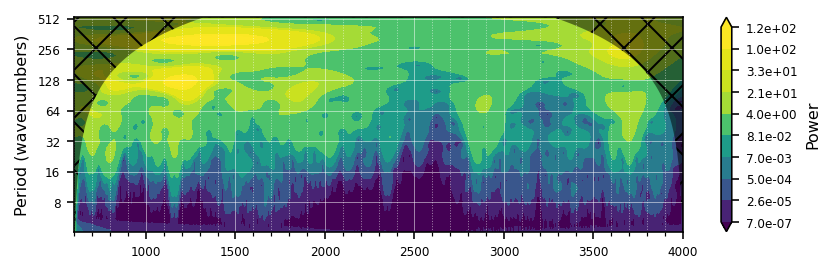

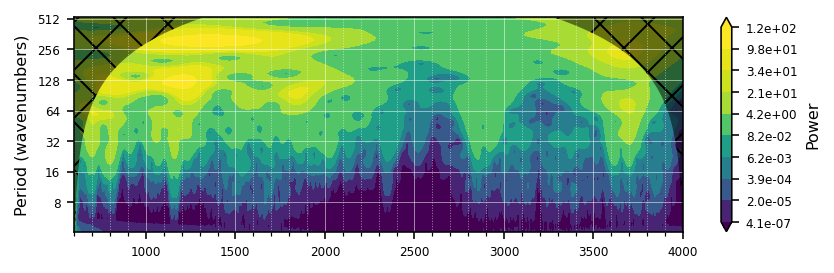

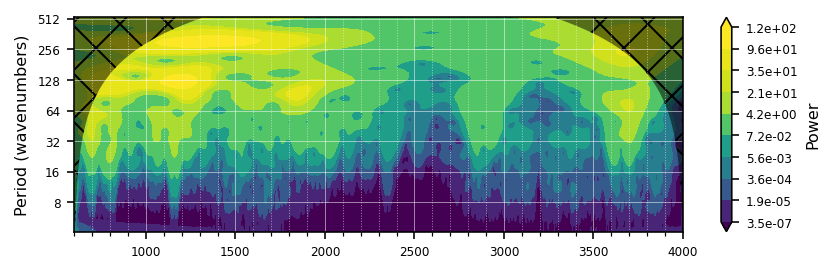

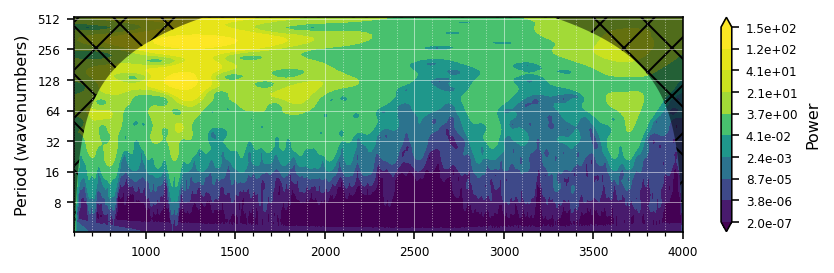

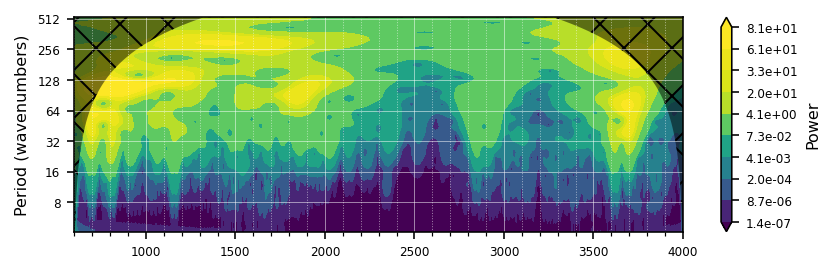

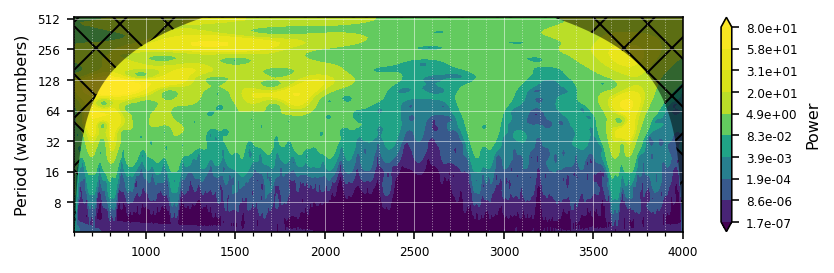

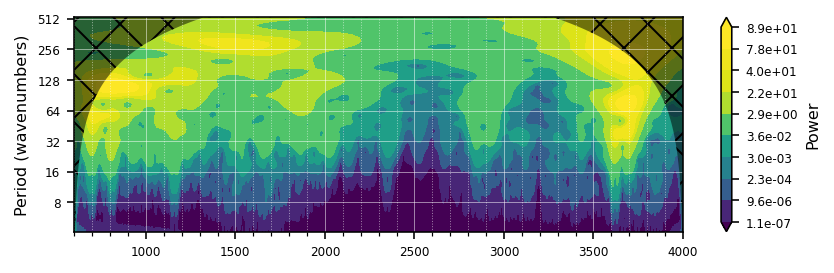

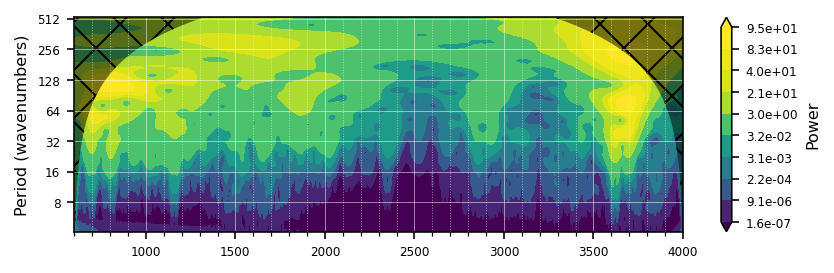

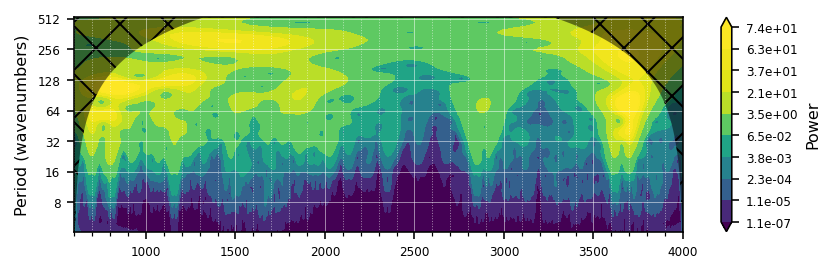

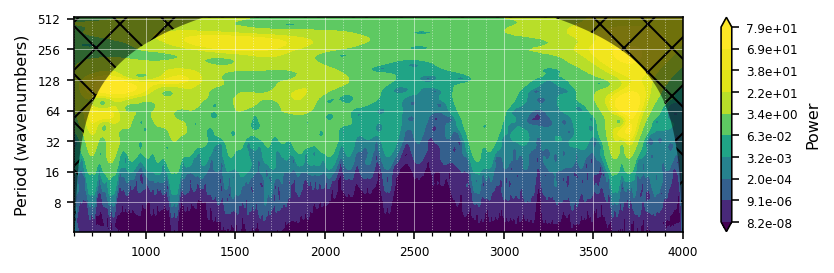

In [ ]:
#| eval: false
for i in range(10):
    plot_cwt(CWT(X_trans[i, :])(), wavenumbers=wavenumbers)

In [ ]:
#| exports
def estimate_conversion_time(seconds=1000, samples=1000):
    """Estimate the time to convert all spectra to images."""
    return seconds * (samples / 1000) / 60
    # print(f'Estimated time: {time:.2f} minutes')

In [ ]:
#| eval: false
%%time
for i, id in enumerate(smp_idx[:1000]):
    fname_img = f'../_data/spectra-img/{id}.png'
    plot_cwt(CWT(X_trans[i, :])(),  wavenumbers=wavenumbers, 
             save_path=fname_img, show_plot=False)

CPU times: user 6min 23s, sys: 4.85 s, total: 6min 28s
Wall time: 2min 15s


In [ ]:
#| eval: false
print(f'It will take: {estimate_conversion_time(seconds=135, samples=57000)} minutes')

It will take: 128.25 minutes


Trying to parallelize the process:

In [ ]:
#| eval: false
%%time
def process_sample(args):
    i, id, X_trans_i, wavenumbers = args
    fname_img = f'../_data/train/{id}.png'
    plot_cwt(CWT(X_trans_i)(), wavenumbers=wavenumbers, 
             save_path=fname_img, show_plot=False)

num_cores = cpu_count()

# # Create the output directory if it doesn't exist
# os.makedirs('../_data/spectra-img', exist_ok=True)

# Prepare the arguments for each sample
args_list = [(i, id, X_trans[i, :], wavenumbers) for i, id in enumerate(smp_idx[:1000])]

# Use a Pool of workers to process the samples in parallel
with Pool(num_cores) as pool:
    pool.map(process_sample, args_list)

CPU times: user 67.2 ms, sys: 140 ms, total: 207 ms
Wall time: 1min 10s


In [ ]:
#| eval: false
print(f'It will take: {estimate_conversion_time(seconds=70, samples=57000)} minutes')

It will take: 66.5 minutes
